# Pipeline to compute attractors/phenotype distribution differences between resistant and sensitive patients and gene differently expression analysis

In [1]:
import pandas as pd
from scipy import stats


from functions.analysis import downstream_analysis
from functions.analysis_utils.MaBoSS_simulation.maboss_phenotype_patient import compute_phenotype_table, collect_group_data,  compute_mean_phenotype_values
from functions.analysis_utils.results_MaBoSS_visualization.boxplot_phenotype import create_boxplot
from functions.analysis_utils.genes_intervention.pers_interventions import tailor_bnd_genes_intervention
from functions.analysis_utils.stats.stats_proba import compute_mannwhitneyu_test_means


from functions.analysis_utils.results_MaBoSS_visualization.create_phenotypes_patients_table import (
    vizualise_table_phenotype_condition, plot_side_by_side_heatmaps
)

from functions.analysis_utils.gene_enrichment.genes_signature import create_results_gene_enrichment

from functions.analysis_utils.results_MaBoSS_visualization.patients_ids_phenotype_table import create_combined_table_patients

from functions.analysis_utils.stats.stats_proba import compute_power_calculation


good results if do not simulate the drug target KO ??
check again what happeens if drug target not blocked

### User data parameters

In [2]:
# models inputs
patients_categ = ['resistant', 'sensitive', 'healthy']

inputs_list = ['EGF', 'FGF', 'TGFb', 'Nutrients', 'Hypoxia', 'Acidosis', 'Androgen', 'TNFalpha', 'SPOP', 'Carcinogen']

# models outputs
phenotype_interest = ["Proliferation","Invasion","DNA_Repair","Apoptosis"]


type_model = 'genes_models'
drug_interest = 'AZD7762' 
drug_targets = ['CHK1_2']

# tissue_interest = 'HAEMATOPOIETIC AND LYMPHOID'


subdir = f"{'_'.join(drug_targets)}_target_block"



# folder_models = f"analysis/{drug_interest}/{type_model}/{subdir}/models"
# folder_results = f"analysis/{drug_interest}/{type_model}/{subdir}"

#blood tissue
# folder_models = f"analysis/{drug_interest}/{type_model}/{subdir}/models"
# folder_results = f"analysis/{drug_interest}/{type_model}/{subdir}"

folder_models = f"analysis/{drug_interest}/{type_model}/{subdir}/models"
folder_results = f"analysis/{drug_interest}/{type_model}/{subdir}"



annotations_models = pd.read_csv('data/model_list_20250407.csv')
# Montagud analysis - Growth factors (EGF and FGF), Nutrients and Androgen ON
# # Montagud analysis - Carcinogen, Androgen, TNFalpha, Acidosis, and Hypoxia
# list_active_inputs =  [['EGF', 'FGF', 'NUTRIENTS', 'ANDROGEN'], 
#                         ['CARCINOGEN', 'ANDROGEN', 'TNF', 'ACIDOSIS', 'HYPOXIA']
#                         ]


### Loading the datasets

In [3]:
# Load top patient IDs from files saved in pipeline 1
with open(f"analysis/{drug_interest}/top_resistant_ids.txt") as f:
    top_resistant_ids = [line.strip() for line in f if line.strip()]

with open(f"analysis/{drug_interest}/top_sensitive_ids.txt") as f:
    top_sensitive_ids = [line.strip() for line in f if line.strip()]


with open(f"analysis/{drug_interest}/top_healthy_ids.txt") as f:
    top_healthy_ids = [line.strip() for line in f if line.strip()]



### Compute attractors/ phenotypes distribution and differential genes expression

In [4]:
# simulate growth factors (EGF and FGF), Nutrients and Androgen ON (cf Montagud paper)
# #  simulate with Carcinogen, Androgen, TNFalpha, Acidosis, and Hypoxia ON. (cf Montagud paper)
# downstream_analysis(folder_results,folder_models, drug_interest, top_resistant_ids, top_sensitive_ids, top_healthy_ids, patients_categ, inputs_list, phenotype_interest, annotations_models, list_active_inputs = list_active_inputs)

In [5]:
folder_models

'analysis/AZD7762/genes_models/CHK1_2_target_block/models'

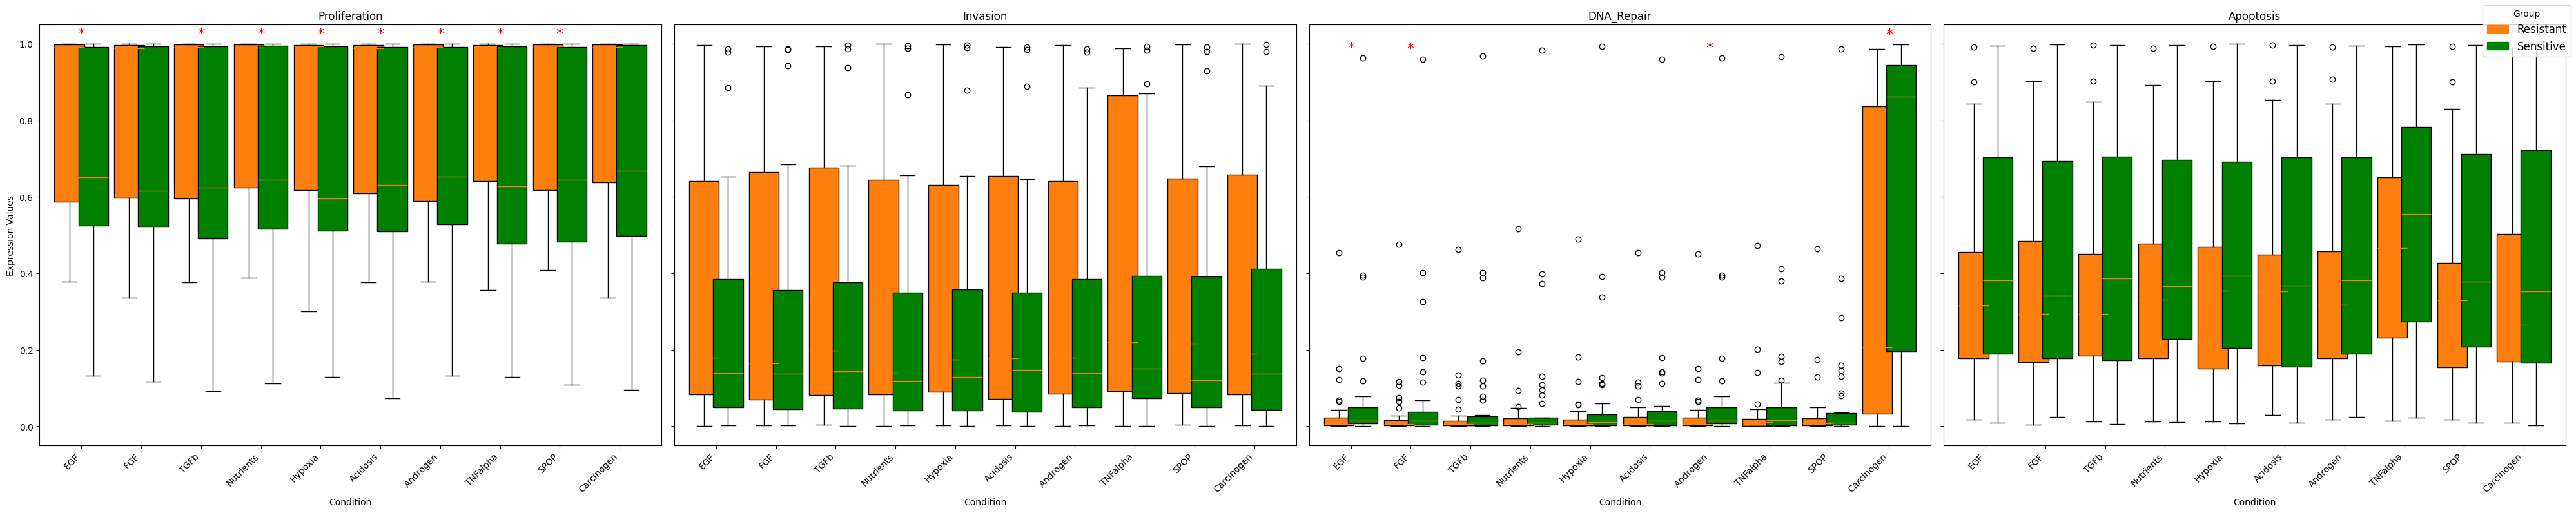

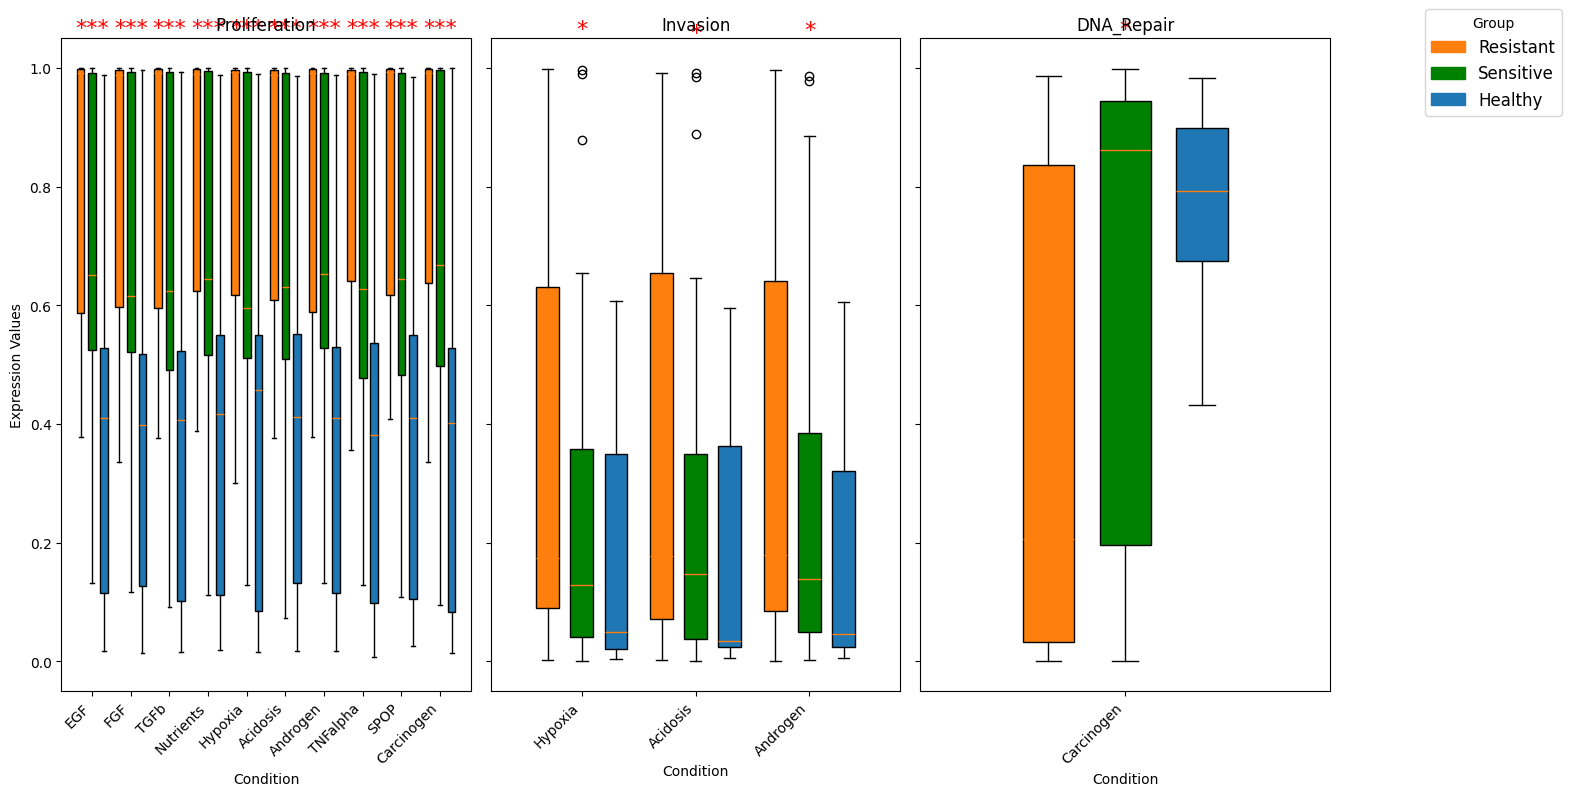

/Users/romane/repos/icr/Attractor-Resistance/functions/analysis_utils/MaBoSS_simulation/maboss_phenotype_patient.py:262: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  patient_mean.loc[condition][phenotype] = mean
/Users/romane/repos/icr/Attr

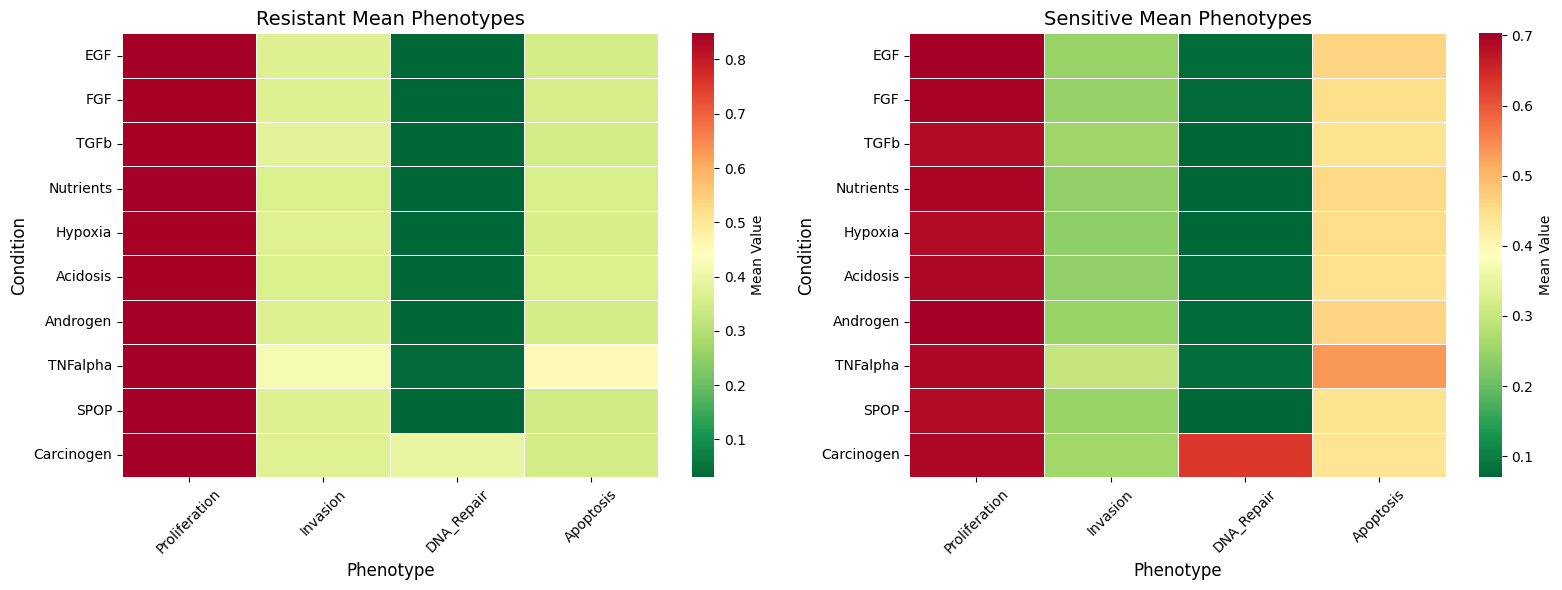

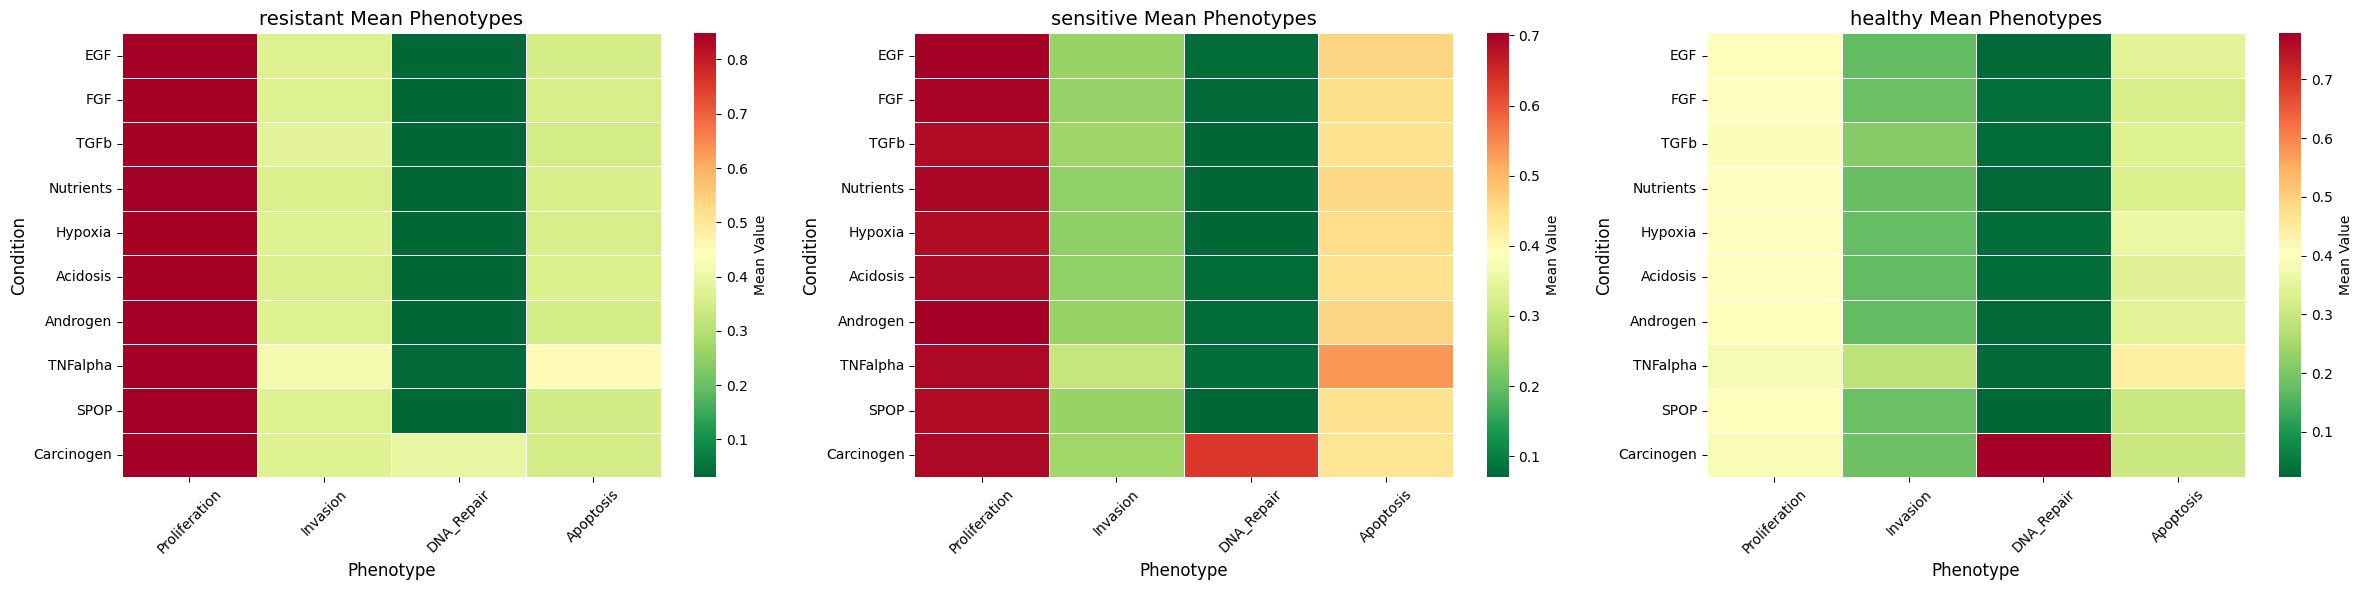

['SIDM00758', 'SIDM00770', 'SIDM00217', 'SIDM00772', 'SIDM01242', 'SIDM00835', 'SIDM00574', 'SIDM00415', 'SIDM00920', 'SIDM00882', 'SIDM00881', 'SIDM00700', 'SIDM00879', 'SIDM00892', 'SIDM00448', 'SIDM01186', 'SIDM00097', 'SIDM01175', 'SIDM00653', 'SIDM00282', 'SIDM00719', 'SIDM01002', 'SIDM00293', 'SIDM00735', 'SIDM00292', 'SIDM00319', 'SIDM00737', 'SIDM00194', 'SIDM00547', 'SIDM00235', 'SIDM00963', 'SIDM00340', 'SIDM00633', 'SIDM00971', 'SIDM01107', 'SIDM00604', 'SIDM01095', 'SIDM00412', 'SIDM00406', 'SIDM00567', 'SIDM00407', 'SIDM01057', 'SIDM00388', 'SIDM00798', 'SIDM00428', 'SIDM00561', 'SIDM00211', 'SIDM00576', 'SIDM00459', 'SIDM01009', 'SIDM00277', 'SIDM01023', 'SIDM00264', 'SIDM00449', 'SIDM00875', 'SIDM01015', 'SIDM01003', 'SIDM01017', 'SIDM00657', 'SIDM01005', 'SIDM01010', 'SIDM01038', 'SIDM01076', 'SIDM01248', 'SIDM00544', 'SIDM00949', 'SIDM00421', 'SIDM00233', 'SIDM00740', 'SIDM00437']
Saved final phenotype table to: analysis/AZD7762/genes_models/CHK1_2_target_block/results

/Users/romane/repos/icr/Attractor-Resistance/.env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/romane/repos/icr/Attractor-Resistance/.env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/romane/repos/icr/Attractor-Resistance/.env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/romane/repos/icr/Attractor-Resistance/.env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*sampl

In [6]:
# for each input ON at a time 
downstream_analysis(folder_results,folder_models, drug_interest, top_resistant_ids, top_sensitive_ids, top_healthy_ids, patients_categ, inputs_list, phenotype_interest, annotations_models, list_active_inputs = None)

### Downstream analysis - test CTNNB1 gene 

In [7]:
# compute the mean of the genes identified in the previous differential expression genes analysis
genes_diff_expressed = pd.read_csv('analysis/Pictilisib/genes_models/PI3K_target_block/results/genes_diff_expressed/significant_genes_EGF_ON_Invasion.csv', index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'analysis/Pictilisib/genes_models/PI3K_target_block/results/genes_diff_expressed/significant_genes_EGF_ON_Invasion.csv'

In [ ]:
genes_diff_expressed

,Group Resistant Mean,Group Sensitive Mean,Group Resistant Variance,Group Sensitive Variance,P-value
BAD,5.795181,5.334200,0.707532,0.656496,0.020250
BCL2L1,6.344133,5.413888,0.864499,1.139836,0.002955
BMP2,1.649357,0.702408,1.747024,1.741410,0.003539
CASP3,4.544552,5.108985,0.314540,0.509634,0.004918
CASP8,3.644319,4.951750,2.022140,0.527180,0.000223
...,...,...,...,...,...
Haematopoietic and Lymphoid,0.846154,NaN,NaN,NaN,NaN
Esophagus,0.038462,NaN,NaN,NaN,NaN
Soft Tissue,0.038462,NaN,NaN,NaN,NaN
Endometrium,0.038462,NaN,NaN,NaN,NaN


In [ ]:


# Find the integer position of the index label 'VHL'
cutoff_position = genes_diff_expressed.index.get_loc('YWHAZ')

# Slice the DataFrame up to that position
genes_diff_expressed_table = genes_diff_expressed.iloc[:cutoff_position + 1]

# # Optional: reset index if needed
# genes_diff_expressed_table.reset_index(inplace=True)


In [ ]:
values_ctnnb1_healthy = list(rna_seq_data[
    (rna_seq_data['model_id'].isin(top_healthy_ids)) &
    (rna_seq_data['gene_symbol'] == 'CTNNB1')
]['rsem_tpm'])


values_ctnnb1_resistant = list(rna_seq_data[
    (rna_seq_data['model_id'].isin(top_resistant_ids)) &
    (rna_seq_data['gene_symbol'] == 'CTNNB1')
]['rsem_tpm'])

values_ctnnb1_sensitive = list(rna_seq_data[
    (rna_seq_data['model_id'].isin(top_sensitive_ids)) &
    (rna_seq_data['gene_symbol'] == 'CTNNB1')
]['rsem_tpm'])

NameError: name 'rna_seq_data' is not defined

In [ ]:
# kruskal test
result = stats.kruskal(values_ctnnb1_healthy, values_ctnnb1_resistant, values_ctnnb1_sensitive)
result

KruskalResult(statistic=np.float64(9.793832980346622), pvalue=np.float64(0.007469580120591721))